In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/PoojaPremnath2003/MediaEval_NewsImages

Cloning into 'MediaEval_NewsImages'...
remote: Enumerating objects: 36292, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 36292 (delta 1), reused 8 (delta 1), pack-reused 36284
Receiving objects: 100% (36292/36292), 1.05 GiB | 40.70 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (62861/62861), done.


In [ ]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-4-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


##Custom Dataset

In [ ]:
#Create Dataframe
df = pd.read_csv("captions.csv")
df.head()

In [ ]:
ids = [id_ for id_ in range(len(df))]
df['id'] = ids
df.head()

In [ ]:
df.to_csv("captions.csv", index=False)

In [ ]:
#image_path = '/content/MediaEval_NewsImages/Training Dataset'
image_path='/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test'
captions_path = "/content"

## Config

*A note on config and CFG: I wrote the codes with python scripts and then converted it into a Jupyter Notebook. So, in case of python scripts, config is a normal python file where I put all the hyperparameters and in the case of Jupyter Notebook, its a class defined in the beginning of the notebook to keep all the hyperparameters.*

In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and captions must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        try:
            image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
            item['caption'] = self.captions[idx]
        except Exception as e:
            print(f"Error loading or processing image at index {idx}: {e}")
            # Return a dummy item or handle in a way appropriate for your application
            item['image'] = torch.zeros((3, CFG.size, CFG.size), dtype=torch.float32)
            item['caption'] = f"Error at index {idx}"

        return item

    def __len__(self):
        return len(self.captions)

    '''def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)'''



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=f98931ba2e49190859ac3c3f9b2c69e68706803f0070a1b00f02f1d60f88975c
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


## Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

## Train

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [ ]:
'''def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter'''

def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        try:
            batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
            loss = model(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step == "batch":
                lr_scheduler.step()

            count = batch["image"].size(0)
            loss_meter.update(loss.item(), count)

            tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
        except Exception as e:
            print(f"Error processing batch during training: {e}")
            # Continue with the next batch

    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        try:
            batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
            loss = model(batch)

            count = batch["image"].size(0)
            loss_meter.update(loss.item(), count)

            tqdm_object.set_postfix(valid_loss=loss_meter.avg)
        except Exception as e:
            print(f"Error processing batch during validation: {e}")
            # Continue with the next batch

    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

In [ ]:
import torch
from torchviz import make_dot

# Assuming all the required classes and functions are already defined

# Instantiate the CLIPModel
model = CLIPModel().to(CFG.device)

# Create dummy input tensors for visualization
dummy_image = torch.randn(1, 3, 224, 224).to(CFG.device)  # Assuming RGB image with size 224x224
dummy_input_ids = torch.randint(1000, (1, 20)).to(CFG.device)  # Assuming sequence length of 20
dummy_attention_mask = torch.ones(1, 20).to(CFG.device)  # Assuming sequence length of 20

dummy_batch = {"image": dummy_image, "input_ids": dummy_input_ids, "attention_mask": dummy_attention_mask}

# Visualize the model
dot = make_dot(model(dummy_batch), params=dict(model.named_parameters()))

# Save the visualization as an image
dot.render("clip_model", format="png", cleanup=True)


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

'clip_model.png'

In [ ]:
import torch
from torchviz import make_dot

# Assuming all the required classes and functions are already defined

# Instantiate the ImageEncoder
image_encoder = ImageEncoder().to(CFG.device)

# Create a dummy image tensor for visualization
dummy_image = torch.randn(1, 3, 224, 224).to(CFG.device)  # Assuming RGB image with size 224x224

# Visualize the image encoder
dot = make_dot(image_encoder(dummy_image), params=dict(image_encoder.named_parameters()))

# Save the visualization as an image
dot.render("image_encoder", format="png", cleanup=True)


'image_encoder.png'

In [ ]:
main()

Epoch: 1


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 4


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/758 [00:00<?, ?it/s]

Error loading or processing image at index 23628: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



  0%|          | 0/190 [00:00<?, ?it/s]

### Getting Image Embeddings

In [ ]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

## Using Saved Weights

In [ ]:
PATH = '/content/best.pt'
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, PATH)

  0%|          | 0/190 [00:00<?, ?it/s]

##Using Trained Weights

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

  0%|          | 0/190 [00:00<?, ?it/s]

### Finding Matches

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 1)
    matches = [image_filenames[idx] for idx in indices[::1]]

    _, axes = plt.subplots(10, 10, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

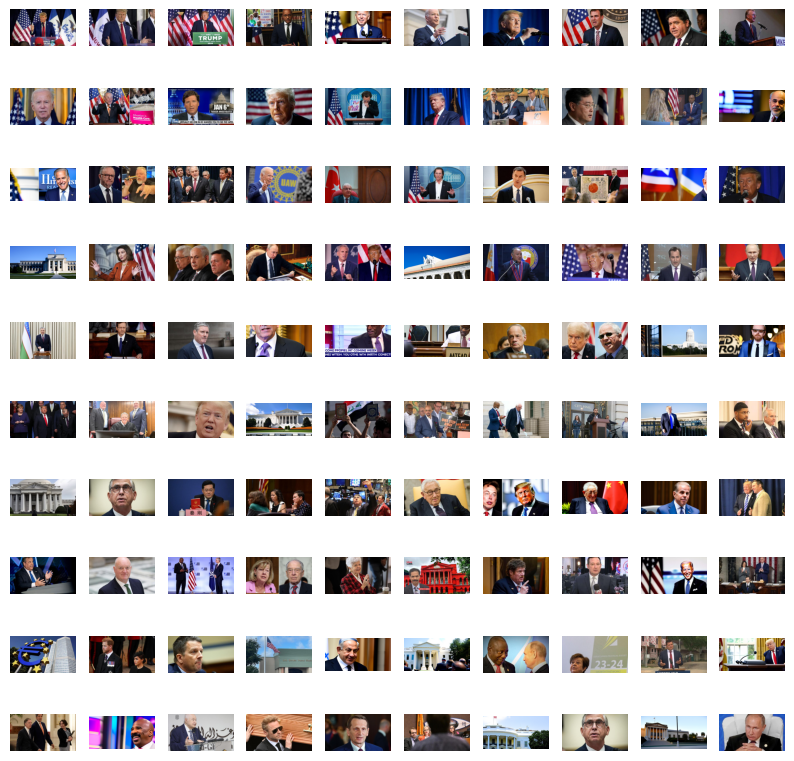

In [ ]:
find_matches(model,
             image_embeddings,
             query="Trump loses bid to move hush-money case to federal court",
             image_filenames=valid_df['image'].values,
             n=100)

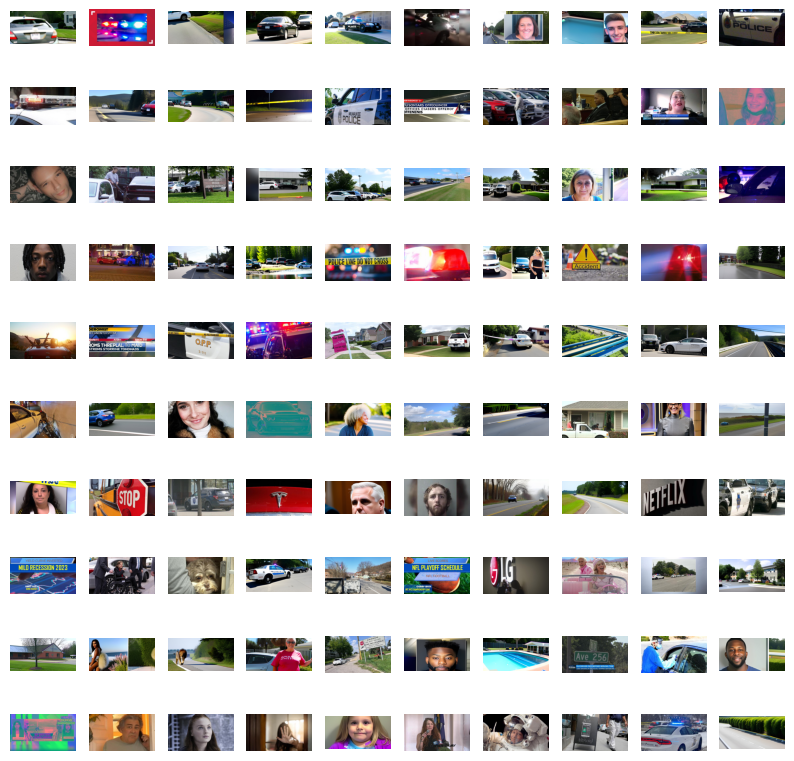

In [ ]:
find_matches(model,
             image_embeddings,
             query="No Evidence Of Toddler On Highway Before Carlee Russell Vanished: Cops carlee nichole russell hoover police department",
             image_filenames=valid_df['image'].values,
             n=100)

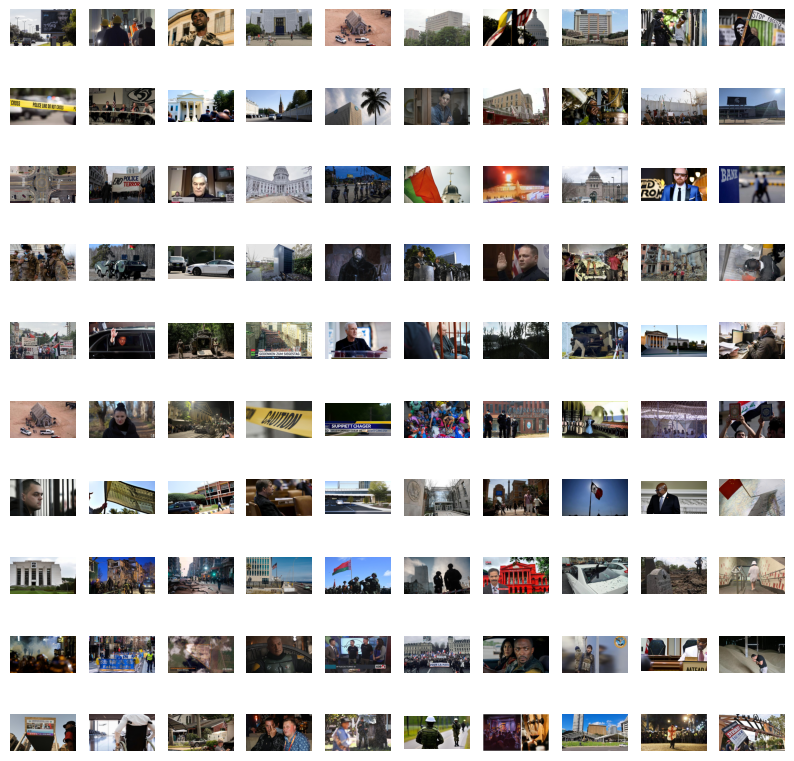

In [ ]:
find_matches(model,
             image_embeddings,
             query="Military veteran who stormed Capitol with loaded pistol is sentenced to 7 years in prison",
             image_filenames=valid_df['image'].values,
             n=100)

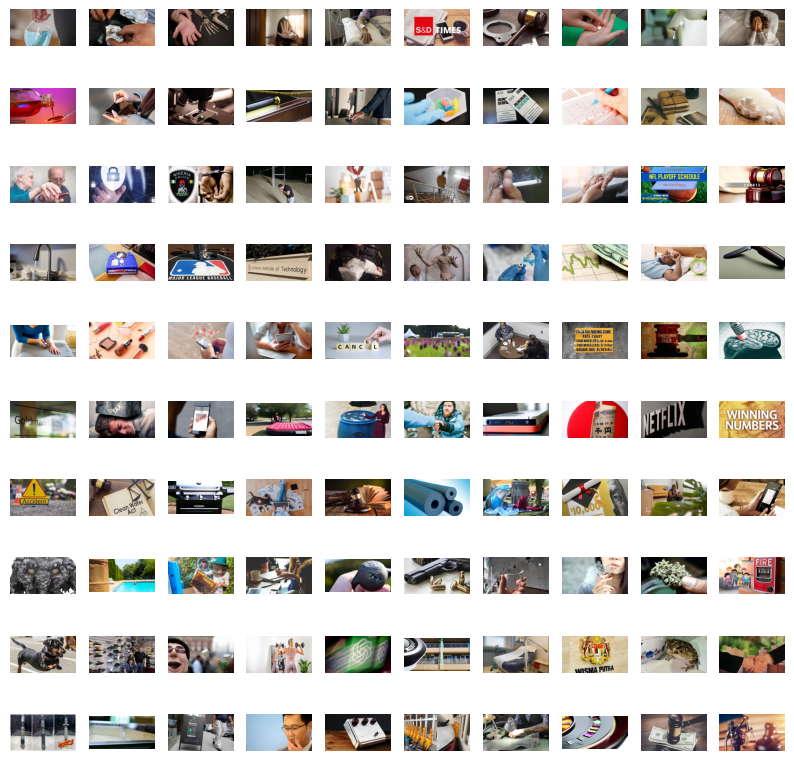

In [ ]:
find_matches(model,
             image_embeddings,
             query="Ukraine and Russia at war- Putin and Zelensky butt heads",
             image_filenames=valid_df['image'].values,
             n=100)

In [ ]:
def find_matches_with_ranking(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [(image_filenames[idx], values[i].item()) for i, idx in enumerate(indices[::5])]

    ranked_matches = sorted(matches, key=lambda x: x[1], reverse=True)

    _, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i, (match, similarity) in enumerate(ranked_matches[:n]):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes.flatten()[i].imshow(image)
        axes.flatten()[i].axis("off")
        axes.flatten()[i].set_title(f"Rank: {i+1}")

    plt.show()

# Example usage
find_matches_with_ranking(model,
                          image_embeddings,
                          query="A girl in a pink dress",
                          image_filenames=valid_df['image'].values,
                          n=100)


NameError: ignored

In [ ]:
import numpy as np
from torch.utils.data import Dataset

class TestImageDataset(Dataset):
    def __init__(self, image_file_paths, transforms):
        self.image_file_paths = image_file_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_file_paths)

    def __getitem__(self, idx):
        image_path = self.image_file_paths[idx]
        image = Image.open(image_path).convert("RGB")

        # Ensure the image has 3 channels
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Convert PIL Image to NumPy array
        image_np = np.array(image)

        transformed_image = self.transforms(image=image_np)["image"]

        return {"image": transformed_image, "image_path": image_path}


In [ ]:
def build_test_image_loader(test_folder):
    image_file_paths = [os.path.join(test_folder, img) for img in os.listdir(test_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    transforms = get_transforms(mode="train")  # Use the same transforms as during training
    test_image_dataset = TestImageDataset(image_file_paths, transforms)
    test_image_loader = torch.utils.data.DataLoader(
        test_image_dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=False,
    )
    return test_image_loader

In [ ]:
model = CLIPModel().to(CFG.device)
model.load_state_dict(torch.load("/content/drive/MyDrive/CLIP_final_weights.pt", map_location=CFG.device))
model.eval()

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [ ]:
test_image_folder = "/content/MediaEval_NewsImages/GDELT-Dataset-2023-Part2/GDELT-P2-Test"

test_image_loader = build_test_image_loader(test_image_folder)
test_image_filenames = [f for f in os.listdir(test_image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]




In [ ]:
from PIL import Image

test_image_embeddings = []
with torch.no_grad():
    for batch in tqdm(test_image_loader):
        #print("Input Shape:", batch["image"].shape)
        image_features = model.image_encoder(batch["image"].permute(0, 3, 1, 2).to(CFG.device))
        image_embeddings = model.image_projection(image_features)
        test_image_embeddings.append(image_embeddings)

test_image_embeddings = torch.cat(test_image_embeddings)

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
query_sentence = "Oxford researcher to watch Barbie as 'dessert' to Oppenheimer amid dual premiere murphy christopher nolan matt damon margot robbie sander wagner ryan gosling greta gerwig florence pugh j robert oppenheimer emily blunt matt durrant association news oxford oxford university"

encoded_query = tokenizer([query_sentence])
batch = {key: torch.tensor(values).to(CFG.device) for key, values in encoded_query.items()}
with torch.no_grad():
    text_features = model.text_encoder(
        input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
    )
    text_embeddings = model.text_projection(text_features)



In [ ]:


def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n)

    # Ensure indices are within the range of image_filenames
    valid_indices = [idx for idx in indices if 0 <= idx < len(image_filenames)]

    # Modify this line to include the full path
    matches = [os.path.join(test_image_folder, image_filenames[idx]) for idx in valid_indices]
    print(matches)
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(match)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()



In [ ]:
#test_image_file_paths = "/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test"

['/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/F661C27EBA33FEF2CBF37D770BF2BF5F.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/815A8A90A296FD9EDE3F9DB9FD5C89F2.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/1E3294E67A5B0A05477BD6B3BB72D694.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/4742AE6DC3B5366F95A843F9E459C304.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/47C15C4489D2656D37A17CB47ED10DCB.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/F9908297D7320ABC8F86C32DC46241F7.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/D2E09799947CC535E8BF2C3942C464D6.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/771E6615F1CAF4E3D8F3C925D543A1B7.jpg', '/content/MediaEval_NewsImages/GDELT-Dataset/GDELT-P1-Test/994C1E1B61A9BF25902EAEF911D1060D.jpg']


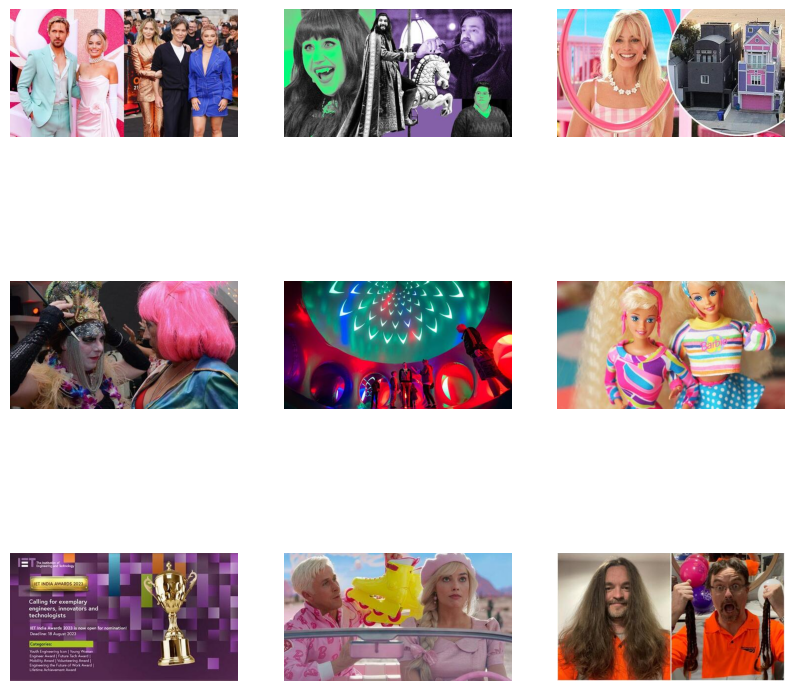

In [ ]:
# Find similar images based on the query sentence
find_matches(model,test_image_embeddings,query_sentence,test_image_filenames,n=9)

In [ ]:
df = pd.read_csv('/content/GDELT-P2-Test-Text.csv')
df.head()